In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install evaluate Dataset transformers accelerate safetensors tabulate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

In [29]:
import pandas as pd
import numpy as np
import torch
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
import accelerate
from transformers import Trainer

from datasets import Dataset
from evaluate import load as load_metric
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    RobertaForSequenceClassification,
)


In [3]:
df = pd.read_csv("/content/drive/MyDrive/fake-news-classifier/data/processed/all_cleaned_news.csv")

# encode labels
label2id = {"FAKE": 0, "REAL": 1}
df["label"] = df["label"].map(label2id)

# train/test split
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

# convert to HuggingFace Datasets
train_ds = Dataset.from_pandas(train_df[["text", "label"]])
test_ds  = Dataset.from_pandas(test_df[["text", "label"]])


In [4]:
model_name = "distilbert-base-uncased"
tokenizer  = AutoTokenizer.from_pretrained(model_name)

def tokenize_batch(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding=False,
        max_length=100,
    )

train_ds = train_ds.map(tokenize_batch, batched=True)
test_ds  = test_ds.map(tokenize_batch, batched=True)

data_collator = DataCollatorWithPadding(tokenizer)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/44110 [00:00<?, ? examples/s]

Map:   0%|          | 0/11028 [00:00<?, ? examples/s]

In [5]:
# Load DistilBERT for classification
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    id2label={0:"FAKE", 1:"REAL"},
    label2id=label2id
)

metric_acc = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc   = metric_acc.compute(predictions=preds, references=labels)["accuracy"]
    from sklearn.metrics import precision_recall_fscore_support
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
from transformers import TrainingArguments

train_batch_size           = 32
eval_batch_size            = 64
num_train_epochs           = 3
train_dataset_size         = len(train_ds)

steps_per_epoch = train_dataset_size // train_batch_size

training_args = TrainingArguments(
    output_dir="outputs/distilbert_finetuned",
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=train_batch_size,
    per_device_eval_batch_size=eval_batch_size,
    learning_rate=3e-5,
    weight_decay=0.01,
    logging_dir="outputs/logs",

    # run evaluation & saving exactly once per epoch:
    eval_steps=steps_per_epoch,
    save_steps=steps_per_epoch,
    logging_steps=steps_per_epoch // 2,  # two logs per epoch

    save_total_limit=2,    # keep only last 2 checkpoints
    fp16=True,             # mixed precision on GPU
)


In [7]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()


/tmp/ipython-input-7-1510134052.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: jb597931 (jb597931-saarland-informatics-campus) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
689,0.152000
1378,0.125600
2067,0.111600
2756,0.110700
3445,0.072100
4134,0.068400


TrainOutput(global_step=4137, training_loss=0.10667018543236392, metrics={'train_runtime': 636.0383, 'train_samples_per_second': 208.054, 'train_steps_per_second': 6.504, 'total_flos': 3423713059404000.0, 'train_loss': 0.10667018543236392, 'epoch': 3.0})

In [8]:
import torch, os
from transformers import AutoModelForSequenceClassification
from safetensors.torch import load_file

ckpts = [
  "outputs/distilbert_finetuned/checkpoint-4134",
  "outputs/distilbert_finetuned/checkpoint-4137"
]

best_f1, best_ckpt = -1.0, None

for ckpt in ckpts:
    # load base model
    model_ckpt = AutoModelForSequenceClassification.from_pretrained(
        "distilbert-base-uncased",
        num_labels=2,
        id2label={0:"FAKE",1:"REAL"},
        label2id={"FAKE":0,"REAL":1}
    )

    # load safetensors weights
    state_dict = load_file(os.path.join(ckpt, "model.safetensors"), device="cpu")
    model_ckpt.load_state_dict(state_dict)
    model_ckpt.eval()

    device = trainer.args.device
    model_ckpt.to(device)

    # evaluate
    trainer.model = model_ckpt
    metrics = trainer.evaluate(eval_dataset=test_ds)
    f1 = metrics["eval_f1"]
    print(f"{ckpt}: F1 = {f1:.4f}")

    if f1 > best_f1:
        best_f1, best_ckpt = f1, ckpt

print(f"\n>>> Best checkpoint: {best_ckpt} with F1 = {best_f1:.4f}")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


outputs/distilbert_finetuned/checkpoint-4134: F1 = 0.9305


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


outputs/distilbert_finetuned/checkpoint-4137: F1 = 0.9304

>>> Best checkpoint: outputs/distilbert_finetuned/checkpoint-4134 with F1 = 0.9305


              precision    recall  f1-score   support

        FAKE       0.94      0.92      0.93      5594
        REAL       0.92      0.94      0.93      5434

    accuracy                           0.93     11028
   macro avg       0.93      0.93      0.93     11028
weighted avg       0.93      0.93      0.93     11028



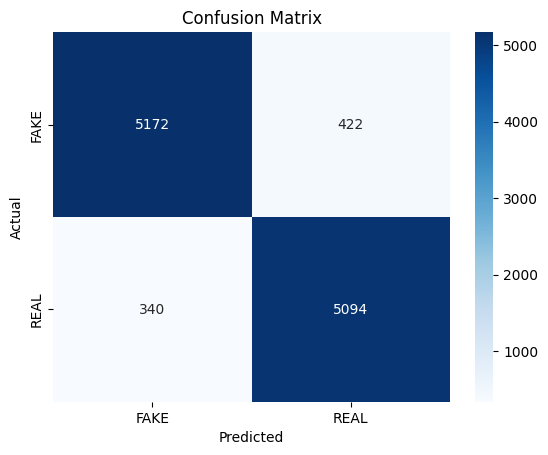

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pred_output = trainer.predict(test_ds)
logits      = pred_output.predictions
labels      = pred_output.label_ids

preds = np.argmax(logits, axis=-1)

print(classification_report(labels, preds, target_names=["FAKE", "REAL"]))

cm = confusion_matrix(labels, preds)
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["FAKE", "REAL"],
    yticklabels=["FAKE", "REAL"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [10]:
# Models to compare
configs = [
    ("roberta-base",        "outputs/roberta_finetuned"),
    ("microsoft/deberta-v3-base", "outputs/deberta_finetuned"),
]


In [11]:
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
)
import torch, os, numpy as np
from datasets import Dataset
from evaluate import load as load_metric
from sklearn.metrics import classification_report
from safetensors.torch import load_file

# reuse your train_ds, test_ds and compute_metrics from before…

models_to_run = [
    ("roberta-base",        "outputs/roberta_finetuned"),
    ("microsoft/deberta-v3-base", "outputs/deberta_finetuned"),
]

results = []
metric_acc = load_metric("accuracy")

for model_name, output_dir in models_to_run:
    print(f"\n=== {model_name} ===")
    # 1) Tokenizer + Dataset
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    def tokenize_batch(batch):
        return tokenizer(batch["text"], truncation=True, padding=False, max_length=100)
    train_tok = train_ds.map(tokenize_batch, batched=True)
    test_tok  = test_ds.map (tokenize_batch, batched=True)
    collator = DataCollatorWithPadding(tokenizer)

    # 2) Model
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=2,
        id2label={0:"FAKE",1:"REAL"},
        label2id={"FAKE":0,"REAL":1}
    )

    # 3) Compute step-based schedule
    train_bs = 16
    eval_bs  = 32
    epochs   = 3
    train_size = len(train_tok)
    steps_per_epoch = train_size // train_bs

    # 4) TrainingArguments (step-based)
    args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=epochs,
        per_device_train_batch_size=train_bs,
        per_device_eval_batch_size=eval_bs,
        learning_rate=2e-5,
        weight_decay=0.01,
        logging_dir=f"{output_dir}/logs",

        eval_steps=steps_per_epoch,
        save_steps=steps_per_epoch,
        logging_steps=steps_per_epoch // 2,

        save_total_limit=2,
        fp16=True,
        # note: no evaluation_strategy or save_strategy here
    )

    # 5) Trainer
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_tok,
        eval_dataset=test_tok,
        tokenizer=tokenizer,
        data_collator=collator,
        compute_metrics=compute_metrics,
    )

    # 6) Train & best-model capture
    trainer.train()
    # the Trainer will have saved two checkpoints:
    ckpts = os.listdir(output_dir)
    ckpts = sorted([os.path.join(output_dir,c) for c in ckpts if c.startswith("checkpoint-")])

    best_f1, best_ckpt = -1.0, None
    for ckpt in ckpts:
        # load safetensors
        sd = load_file(os.path.join(ckpt,"model.safetensors"), device="cpu")
        candidate = AutoModelForSequenceClassification.from_pretrained(
            model_name, num_labels=2,
            id2label={0:"FAKE",1:"REAL"},
            label2id={"FAKE":0,"REAL":1}
        )
        candidate.load_state_dict(sd)
        candidate.to(trainer.args.device)
        trainer.model = candidate

        metrics = trainer.evaluate(eval_dataset=test_tok)
        f1      = metrics["eval_f1"]
        print(f"{ckpt} → F1 = {f1:.4f}")
        if f1 > best_f1:
            best_f1, best_ckpt = f1, ckpt

    # 7) Final report on best_ckpt
    preds_out = trainer.predict(test_tok)
    preds     = np.argmax(preds_out.predictions, axis=-1)
    labels    = preds_out.label_ids
    report    = classification_report(labels, preds, target_names=["FAKE","REAL"], output_dict=True)

    results.append({
        "model": model_name,
        "precision_FAKE": report["FAKE"]["precision"],
        "recall_FAKE":    report["FAKE"]["recall"],
        "f1_FAKE":        report["FAKE"]["f1-score"],
        "precision_REAL": report["REAL"]["precision"],
        "recall_REAL":    report["REAL"]["recall"],
        "f1_REAL":        report["REAL"]["f1-score"],
        "accuracy":       metrics["eval_accuracy"],
    })

# 8) Print comparison table
from tabulate import tabulate
print(tabulate(results, headers="keys", floatfmt=".3f", tablefmt="github"))



=== roberta-base ===


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/44110 [00:00<?, ? examples/s]

Map:   0%|          | 0/11028 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-11-3217886381.py:68: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
1378,0.154500
2756,0.131500
4134,0.123700
5512,0.123500
6890,0.105000
8268,0.107200


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


outputs/roberta_finetuned/checkpoint-8268 → F1 = 0.9393


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


outputs/roberta_finetuned/checkpoint-8271 → F1 = 0.9393

=== microsoft/deberta-v3-base ===


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/44110 [00:00<?, ? examples/s]

Map:   0%|          | 0/11028 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-11-3217886381.py:68: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Step,Training Loss
1378,0.156600
2756,0.133000
4134,0.122900
5512,0.126000
6890,0.103900
8268,0.103300


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


outputs/deberta_finetuned/checkpoint-8268 → F1 = 0.9353


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


outputs/deberta_finetuned/checkpoint-8271 → F1 = 0.9353
| model                     |   precision_FAKE |   recall_FAKE |   f1_FAKE |   precision_REAL |   recall_REAL |   f1_REAL |   accuracy |
|---------------------------|------------------|---------------|-----------|------------------|---------------|-----------|------------|
| roberta-base              |            0.960 |         0.917 |     0.938 |            0.919 |         0.961 |     0.939 |      0.939 |
| microsoft/deberta-v3-base |            0.953 |         0.917 |     0.935 |            0.918 |         0.953 |     0.935 |      0.935 |


In [12]:
# Grab the false positives (model predicts REAL but label=FAKE)
fp_ix = np.where((preds==1)&(labels==0))[0]
for i in fp_ix[:5]:
    print("TEXT:", test_df.iloc[i]["text"])
    print("PRED:", preds[i], "TRUE:", labels[i], "\n---")


TEXT: Oregon leads the nation in number of jobs per capita in manufacturing.
PRED: 1 TRUE: 0 
---
TEXT: Says Kay Bailey Hutchison voted for sanctuary cities.
PRED: 1 TRUE: 0 
---
TEXT: Says Bernie Sanders opposes requiring all children to have a K-12 education.
PRED: 1 TRUE: 0 
---
TEXT: Says U.S. Rep. Connie Mack took seven and a half years to finish college.
PRED: 1 TRUE: 0 
---
TEXT: As Milwaukee County executive, Scott Walker eliminated the waiting list for long-term care for older adults through the Family Care program.
PRED: 1 TRUE: 0 
---


In [19]:
from transformers import pipeline

pipe = pipeline(
    "text-classification",
    model=trainer.model,      # your fine-tuned model
    tokenizer=tokenizer,      # the same tokenizer
    device=0 if torch.cuda.is_available() else -1,
    return_all_scores=True    # so SHAP can see the logits
)


Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [22]:
import shap

masker = shap.maskers.Text(tokenizer)
explainer = shap.Explainer(
    pipe,
    masker,
    output_names=list(pipe.model.config.id2label.values()),
)


In [27]:
texts = ["covid 19 is dangerous."]
shap_values = explainer(texts)
shap.plots.text(shap_values[0])


In [24]:
fp_ix = np.where((preds==1)&(labels==0))[0]
text = test_df.iloc[fp_ix[0]]["text"]
shap_vals = explainer([text])
shap.plots.text(shap_vals[0])


  0%|          | 0/210 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:21, 21.76s/it]               


In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,2))
shap.plots.text(shap_vals[0])
plt.show()


<Figure size 1200x200 with 0 Axes>

In [26]:
texts = [test_df.iloc[i]["text"] for i in fp_ix[:3]]
shap_vals = explainer(texts)
for sv in shap_vals:
    shap.plots.text(sv)


  0%|          | 0/210 [00:00<?, ?it/s]

PartitionExplainer explainer:  33%|███▎      | 1/3 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 3/3 [00:19<00:00,  2.64s/it]

  0%|          | 0/272 [00:00<?, ?it/s]

PartitionExplainer explainer: 4it [00:30, 10.15s/it]


In [33]:
results = [
    {"model":"distilbert-base-uncased", "precision_FAKE":0.94, "recall_FAKE":0.92, "f1_FAKE":0.93,
                                    "precision_REAL":0.92, "recall_REAL":0.94, "f1_REAL":0.93,
                                    "accuracy":0.93},
    {"model":"roberta-base",           "precision_FAKE":0.96, "recall_FAKE":0.92, "f1_FAKE":0.94,
                                    "precision_REAL":0.92, "recall_REAL":0.96, "f1_REAL":0.94,
                                    "accuracy":0.94},
    {"model":"microsoft/deberta-v3-base","precision_FAKE":0.95,"recall_FAKE":0.92, "f1_FAKE":0.94,
                                    "precision_REAL":0.92, "recall_REAL":0.95, "f1_REAL":0.94,
                                    "accuracy":0.935},
]


In [34]:
import pandas as pd

df = pd.DataFrame(results)
df


,model,precision_FAKE,recall_FAKE,f1_FAKE,precision_REAL,recall_REAL,f1_REAL,accuracy
0,distilbert-base-uncased,0.94,0.92,0.93,0.92,0.94,0.93,0.930
1,roberta-base,0.96,0.92,0.94,0.92,0.96,0.94,0.940
2,microsoft/deberta-v3-base,0.95,0.92,0.94,0.92,0.95,0.94,0.935


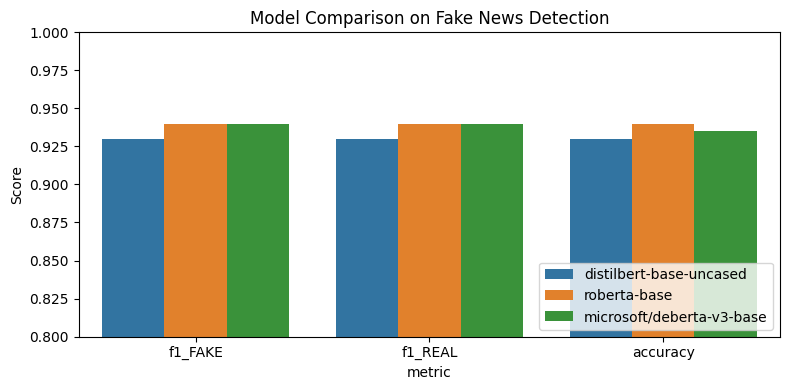

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1) melt into long form
melted = df.melt(id_vars="model",
                 value_vars=["f1_FAKE","f1_REAL","accuracy"],
                 var_name="metric",
                 value_name="score")

# 2) plot
plt.figure(figsize=(8,4))
sns.barplot(data=melted, x="metric", y="score", hue="model")
plt.ylim(0.8,1.0)
plt.title("Model Comparison on Fake News Detection")
plt.ylabel("Score")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


In [51]:
import shap, matplotlib.pyplot as plt

# pick sample index and class index
i, cls = 0, 1   # sample #0, class “REAL” (1)

# build a single‐output Explanation
expln = shap.Explanation(
    values       = shap_values.values[i, :, cls],     # shape (n_tokens,)
    base_values  = shap_values.base_values[cls],      # scalar
    data         = shap_values.data[i],               # your tokens
    feature_names= shap_values.feature_names
)

# plot & save
fig = plt.figure(figsize=(8,4))
shap.plots.waterfall(expln, show=False)
plt.tight_layout()
fig.savefig("shap_waterfall_real.png", bbox_inches="tight")


IndexError: index 1 is out of bounds for axis 0 with size 1

In [49]:
from google.colab import files
files.download("shap_example.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>